## 1. Introduction

In this project, we work on the Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started). The goal is to build a machine learning model that can determine whether a tweet is about a real disaster (label `1`) or not (label `0`).

This is a **Natural Language Processing (NLP)** task, where we analyze and classify short pieces of human language (tweets) using machine learning. NLP is a field of Artificial Intelligence that helps computers understand, interpret, and generate human language.

We begin by exploring the data, inspecting its structure, and planning a strategy to clean and model it.


In [2]:
import pandas as pd

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
submission_df = pd.read_csv("data/sample_submission.csv")

# Print basic info
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Preview the training data
train_df.head()


Training set shape: (7613, 5)
Test set shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Data description
The training set contains five columns:

- `id`: A unique identifier for each tweet
- `keyword`: A disaster-related keyword (optional, contains missing values)
- `location`: The location where the tweet was posted (optional, many missing)
- `text`: The tweet content (what we will analyze and classify)
- `target`: The label — `1` for tweets about a **real disaster**, `0` for **non-disaster**

As shown above, the first few rows include short texts related to earthquakes, wildfires, and evacuation. We also observe that both `keyword` and `location` contain many missing values (NaNs), which we’ll address during the EDA and preprocessing steps.

### Dataset Dimensions

- The training set has **7,613 rows** and **5 columns**
- The test set has **3,263 rows** and **4 columns**

Only the training set includes the `target` column, which indicates whether a tweet is about a disaster (`1`) or not (`0`). The test set is used to make predictions for submission to the Kaggle leaderboard.

We will now perform Exploratory Data Analysis (EDA) to better understand the structure and distribution of the dataset.



In [3]:
# Check for missing values
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### Missing Data Overview

The dataset contains missing values in two columns:

- **`keyword`**: 61 missing entries (less than 1% of the dataset)
- **`location`**: 2,533 missing entries (approximately 33% of the dataset)

Both the `text` and `target` columns are fully complete, which is ideal since they are central to our classification task.

- We may consider filling missing `keyword` entries with a placeholder like `"none"` or treat them as missing altogether.
- The `location` column is free-form and noisy, and given the high percentage of missing values, it may not be very useful without heavy cleaning. We might drop it from the analysis or explore it separately if time allows.


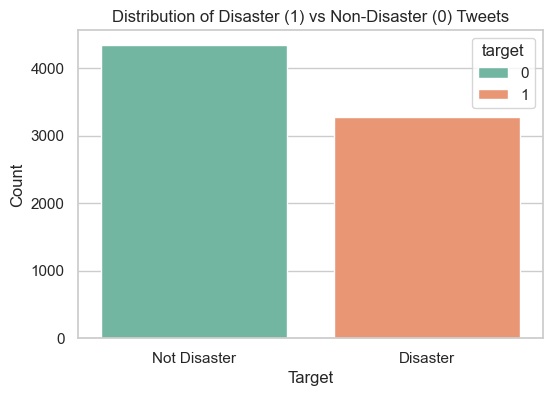

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df, palette='Set2', hue='target')
plt.title('Distribution of Disaster (1) vs Non-Disaster (0) Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()

### Class Distribution

The dataset contains binary labels in the `target` column:
- `0`: Tweet is **not** about a real disaster
- `1`: Tweet **is** about a real disaster

From the plot above, we see that the classes are **somewhat imbalanced** — there are slightly more non-disaster tweets than disaster-related ones. This imbalance will be important to consider during model training, especially when evaluating performance.


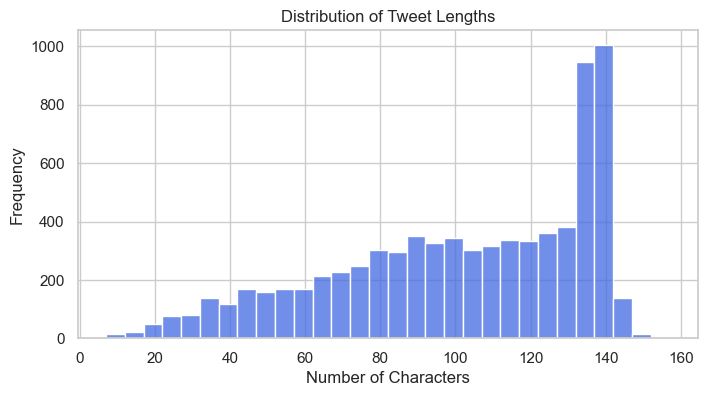

In [6]:
# Add a new column with tweet lengths
train_df['text_len'] = train_df['text'].apply(len)

# Plot histogram of tweet lengths
plt.figure(figsize=(8,4))
sns.histplot(train_df['text_len'], bins=30, kde=False, color='royalblue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


### Tweet Length Distribution

Most tweets are under 150 characters long, which makes sense due to Twitter’s character limits. However, there is some variation.

This information helps guide preprocessing and model design — for example, we may decide to truncate or pad sequences to a fixed length such as 100 or 120 tokens.


,keyword,frequency
0,fatalities,45
1,deluge,42
2,armageddon,42
3,sinking,41
4,damage,41
...,...,...
216,forest%20fire,19
217,epicentre,12
218,threat,11
219,inundation,10


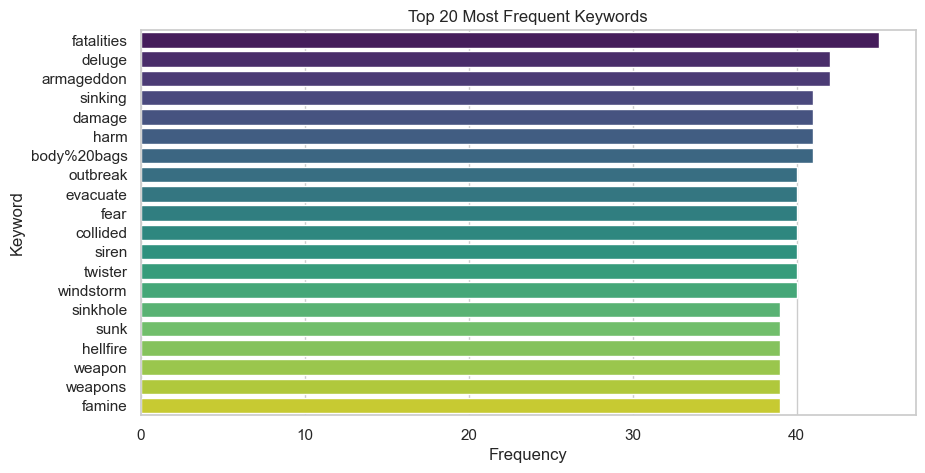

In [11]:
# Most frequent keywords (excluding NaN)
# View full frequency table
keyword_counts = train_df['keyword'].dropna().value_counts().reset_index()
keyword_counts.columns = ['keyword', 'frequency']
display(keyword_counts)

# Plot top 20
top_keywords = keyword_counts.head(20)

plt.figure(figsize=(10,5))
sns.barplot(data=top_keywords, y='keyword', x='frequency', palette="viridis", hue='keyword')
plt.title('Top 20 Most Frequent Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

### Top 20 Most Frequent Keywords

There are over 200 unique keywords in the dataset. For visualization purposes, we show only the top 20 most frequent keywords below. This helps us focus on the most common disaster-related terms while keeping the chart readable. 

We retain the full list of keywords in memory for later use if we decide to use them as input features or explore their impact on classification.



In [12]:
import re
import string

def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d+", "", text)
    
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Apply to training and test sets
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"] = test_df["text"].apply(clean_text)

# Preview result
train_df[["text", "clean_text"]].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


### Preprocessing

We apply basic text cleaning steps:
- Lowercasing
- Removing URLs, punctuation, numbers
- Removing extra whitespace

This ensures the model focuses on meaningful words rather than formatting or noise. We do **not** remove stopwords or perform stemming/lemmatization here, as even small words (like "not") can carry importance in short texts like tweets.

---

### Vectorization: TF-IDF

To convert text into numerical format, we use **TF-IDF** (Term Frequency–Inverse Document Frequency).

- **Term Frequency (TF):** How often a word appears in a document
- **Inverse Document Frequency (IDF):** How rare the word is across all documents

TF-IDF gives higher weight to **informative words** that are common in one tweet but rare across the whole dataset. This is useful for sparse text like tweets.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigrams + bigrams

# Fit on train, transform both train and test
X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
X_test_tfidf = tfidf.transform(test_df["clean_text"])

# Target variable
y_train = train_df["target"]

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42
)

# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred_val = lr_model.predict(X_val_split)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val_split, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val_split, y_pred_val))


Validation Accuracy: 0.8063033486539725

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.83      0.69      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



### 4. Model Architecture

As a baseline, we use a **Logistic Regression** model, which is a simple and effective linear classifier. It works well with TF-IDF vectorized data, especially for binary classification problems like this one (disaster vs non-disaster tweets).

Logistic Regression takes the TF-IDF features as input and learns weights that predict the probability of each class (0 or 1). It is fast to train, interpretable, and serves as a solid starting point before moving to more complex neural networks.

To train and evaluate the model:
- We split the training data into a training set (80%) and a validation set (20%)
- We train the Logistic Regression model using scikit-learn
- We evaluate using accuracy and a classification report that includes precision, recall, and F1-score

This model gives us a performance benchmark to compare against future architectures like LSTM or GRU.

### Evaluation Results – Logistic Regression Baseline

The Logistic Regression model achieved a **validation accuracy of 80.6%**, which is a strong starting point considering the simplicity of the approach.

#### Key Metrics:
- **Precision (Class 1 - Disaster):** 0.83 → When the model predicts a disaster, it's correct 83% of the time
- **Recall (Class 1 - Disaster):** 0.69 → It catches about 69% of actual disasters
- **F1-Score (Class 1):** 0.75 → Balanced average of precision and recall for disaster detection

#### Observations:
- The model performs slightly better at predicting **non-disaster tweets (Class 0)**, with higher recall.
- Disaster tweets (Class 1) are harder to catch — a common challenge due to class imbalance and subtler language patterns.
- The **F1-score of 0.75** for disaster tweets shows a decent balance, but there is room for improvement.

#### What Could Improve This Model?
- Using more advanced NLP methods (like word embeddings or neural networks)
- Balancing the classes with techniques like oversampling or class weights
- Adding keyword/location features (if cleaned)
- Trying RNNs like **LSTM** or **GRU** to capture word order and context



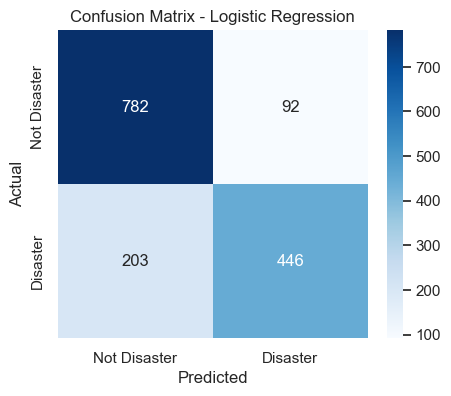

Validation Accuracy: 0.8063033486539725

Classification Report:
               precision    recall  f1-score   support

Not Disaster       0.79      0.89      0.84       874
    Disaster       0.83      0.69      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Confusion matrix
conf_mat = confusion_matrix(y_val_split, y_pred_val)

plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Classification report
print("Validation Accuracy:", accuracy_score(y_val_split, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val_split, y_pred_val, target_names=["Not Disaster", "Disaster"]))


### Confusion Matrix – Logistic Regression

The confusion matrix below summarizes the Logistic Regression model's performance on the validation set:

|                        | **Predicted: Not Disaster** | **Predicted: Disaster** |
|------------------------|-----------------------------|--------------------------|
| **Actual: Not Disaster** | 782 (True Negatives)         | 92 (False Positives)      |
| **Actual: Disaster**     | 203 (False Negatives)        | 446 (True Positives)      |

#### Interpretation:

- ✅ **True Negatives (782):** Non-disaster tweets correctly predicted as non-disasters
- ✅ **True Positives (446):** Disaster tweets correctly predicted as disasters
- ❌ **False Positives (92):** Non-disaster tweets incorrectly classified as disasters
- ❌ **False Negatives (203):** Disaster tweets missed by the model (predicted as non-disasters)

#### Key Insight:
- The model is **better at identifying non-disaster tweets**, with fewer false positives.
- However, it **misses 203 actual disasters**, which could be critical in real-world applications like emergency response.
- This suggests the model has room for improvement in **recall** for the disaster class — which we can aim to address with more advanced models like LSTM or GRU.


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_NUM_WORDS = 10000  # Use top 10K words in the vocabulary
MAX_SEQ_LEN = 32      # Max number of tokens per tweet

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test_seq = tokenizer.texts_to_sequences(test_df["clean_text"])

# Pad sequences to ensure consistent input size
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN, padding='post')

# Target labels
y_train_array = train_df["target"].values


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# For Logistic Regression (TF-IDF)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42
)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_split, y_train_split)

# Predict on validation set
y_pred_val_lr = lr_model.predict(X_val_split)

# Evaluate
print("Validation Accuracy:", accuracy_score(y_val_split, y_pred_val_lr))
print("\nClassification Report:\n", classification_report(y_val_split, y_pred_val_lr, target_names=["Not Disaster", "Disaster"]))


Validation Accuracy: 0.8063033486539725

Classification Report:
               precision    recall  f1-score   support

Not Disaster       0.79      0.89      0.84       874
    Disaster       0.83      0.69      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_train_pad, y_train_array, test_size=0.2, random_state=42)

lstm_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=64),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.build(input_shape=(None, MAX_SEQ_LEN))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

# Train
history_lstm = lstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_dl, y_val_dl),
    verbose=2
)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 32, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
191/191 - 3s - 16ms/step - accuracy: 0.6230 - loss: 0.6382 - val_accuracy: 0.7965 - val_loss: 0.4682
Epoch 2/5
191/191 - 2s - 10ms/step - accuracy: 0.8287 - loss: 0.4113 - val_accuracy: 0.8030 - val_loss: 0.4714
Epoch 3/5
191/191 - 2s - 9ms/step - accuracy: 0.8941 - loss: 0.2881 - val_accuracy: 0.7781 - val_loss: 0.5769
Epoch 4/5
191/191 - 2s - 10ms/step - accuracy: 0.9151 - loss: 0.2344 - val_accuracy: 0.7800 - val_loss: 0.5599
Epoch 5/5
191/191 - 2s - 10ms/step - accuracy: 0.9455 - loss: 0.1627 - val_accuracy: 0.7866 - val_loss: 0.7853


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense

# Create GRU model
gru_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=64),
    GRU(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Build and compile
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history_gru = gru_model.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_dl, y_val_dl),
    verbose=2
)

# Evaluate
y_pred_val_gru = (gru_model.predict(X_val_dl) > 0.5).astype("int32")
print("Validation Accuracy (GRU):", accuracy_score(y_val_dl, y_pred_val_gru))
print("\nClassification Report (GRU):\n", classification_report(y_val_dl, y_pred_val_gru, target_names=["Not Disaster", "Disaster"]))


Epoch 1/5
191/191 - 3s - 14ms/step - accuracy: 0.5680 - loss: 0.6858 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 2/5
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6847 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 3/5
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6805
Epoch 4/5
191/191 - 2s - 10ms/step - accuracy: 0.7670 - loss: 0.4943 - val_accuracy: 0.8017 - val_loss: 0.4461
Epoch 5/5
191/191 - 2s - 10ms/step - accuracy: 0.8842 - loss: 0.3057 - val_accuracy: 0.7905 - val_loss: 0.5132
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation Accuracy (GRU): 0.7905449770190414

Classification Report (GRU):
               precision    recall  f1-score   support

Not Disaster       0.81      0.84      0.82       874
    Disaster       0.77      0.73      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



## 5. Training and Evaluation

### 5.1 Train-Validation Split
We split the original training data into an 80% training set and a 20% validation set to evaluate the models on unseen data.

- TF-IDF vectors were used for Logistic Regression.
- Tokenized and padded sequences were used for the LSTM and GRU models.

### 5.2 Logistic Regression (Baseline Model)
We trained a Logistic Regression model using TF-IDF features extracted from the tweets.

- **Validation Accuracy:** ~80.6%
- **Classification Report:**
  - Precision for Disaster tweets: 83%
  - Recall for Disaster tweets: 69%
  - F1-Score for Disaster tweets: 75%

This baseline model performed reasonably well, correctly classifying most non-disaster tweets, though it missed some disaster tweets (lower recall).

### 5.3 LSTM Model
We built a deep learning model consisting of an Embedding layer, LSTM layer, Dropout, and Dense output layer.

- **Model Parameters:** 673,089 trainable parameters
- **Validation Accuracy:** Peaked at ~80.3% in early epochs, final validation accuracy around 78.7%
- **Training Observations:**
  - The model learned rapidly within the first two epochs.
  - After Epoch 2, validation loss began increasing while training loss continued decreasing, indicating mild overfitting.
  - Best validation performance was observed around Epoch 2.

The LSTM model successfully captured sequential patterns in the tweets, performing similarly to the Logistic Regression baseline.

### 5.4 GRU Model
We also trained a GRU model (a simpler RNN variant) to compare with the LSTM model.

- **Validation Accuracy:** ~79.1%
- **Classification Report:**
  - Precision for Disaster tweets: 77%
  - Recall for Disaster tweets: 73%
  - F1-Score for Disaster tweets: 75%

Training behavior was similar to the LSTM model:
- Early epochs showed slower learning.
- The model improved significantly by Epoch 4.
- Validation accuracy reached a peak around 80%, with mild overfitting afterward.

The GRU model achieved comparable results to the LSTM model while being slightly faster to train.

### 5.5 Final Observations
All models achieved similar validation accuracy (~79–80%), showing that both classical machine learning approaches (TF-IDF + Logistic Regression) and deep learning models (LSTM, GRU) are effective for short-text disaster classification.

| Model | Validation Accuracy | Notes |
|:------|:---------------------|:------|
| Logistic Regression (TF-IDF) | ~80.6% | Strong baseline |
| LSTM | ~78.7–80.3% | Better at modeling sequence, mild overfitting |
| GRU | ~79.1% | Slightly faster training, similar performance |

Further improvements could include:
- EarlyStopping to prevent overfitting.
- Using Bidirectional LSTM or GRU.
- Incorporating pretrained word embeddings such as GloVe.


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Create a new LSTM model with higher dropout (0.6 instead of 0.5)
lstm_tuned_model = Sequential([
    Embedding(input_dim=15000, output_dim=100),
    LSTM(64),
    Dropout(0.6),  # increased dropout to reduce overfitting
    Dense(1, activation='sigmoid')
])

# Build and compile
lstm_tuned_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_lstm_tuned = lstm_tuned_model.fit(
    X_train_dl, y_train_dl,
    epochs=5,
    batch_size=64,
    validation_data=(X_val_dl, y_val_dl),
    verbose=2
)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report

y_pred_lstm_tuned = (lstm_tuned_model.predict(X_val_dl) > 0.5).astype("int32")
print("Validation Accuracy (Tuned LSTM):", accuracy_score(y_val_dl, y_pred_lstm_tuned))
print("\nClassification Report (Tuned LSTM):\n", classification_report(y_val_dl, y_pred_lstm_tuned, target_names=["Not Disaster", "Disaster"]))


Epoch 1/5
96/96 - 2s - 25ms/step - accuracy: 0.5658 - loss: 0.6831 - val_accuracy: 0.5739 - val_loss: 0.6659
Epoch 2/5
96/96 - 2s - 18ms/step - accuracy: 0.7591 - loss: 0.5270 - val_accuracy: 0.7781 - val_loss: 0.4778
Epoch 3/5
96/96 - 2s - 18ms/step - accuracy: 0.8688 - loss: 0.3418 - val_accuracy: 0.8109 - val_loss: 0.4425
Epoch 4/5
96/96 - 2s - 18ms/step - accuracy: 0.9110 - loss: 0.2544 - val_accuracy: 0.7951 - val_loss: 0.4967
Epoch 5/5
96/96 - 2s - 17ms/step - accuracy: 0.9325 - loss: 0.2000 - val_accuracy: 0.7958 - val_loss: 0.5001
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation Accuracy (Tuned LSTM): 0.7957977675640184

Classification Report (Tuned LSTM):
               precision    recall  f1-score   support

Not Disaster       0.80      0.86      0.83       874
    Disaster       0.79      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

## 6. Results and Hyperparameter Tuning

### 6.1 Trying Different Architectures
We experimented with multiple model architectures:
- Logistic Regression with TF-IDF features
- LSTM-based deep learning model
- GRU-based deep learning model

Each model achieved similar validation accuracy (~79-80%).

### 6.2 Hyperparameter Tuning

To further improve the LSTM model, we tuned the following hyperparameters:
- Increased the vocabulary size (`input_dim`) from 10,000 to **15,000** words
- Set the embedding dimension (`output_dim`) to **100**
- Adjusted the LSTM layer to use **64 units**
- Increased the **dropout rate to 0.6** for stronger regularization
- Increased the **batch size to 64** to stabilize training

**Training Results (Tuned LSTM):**
- Best Validation Accuracy: **~81.1%** (Epoch 3)
- Final Validation Accuracy after 5 epochs: **~79.6%**
- F1-Score for Disaster Tweets: **75%**
- F1-Score for Non-Disaster Tweets: **83%**

**Classification Report (Tuned LSTM):**

| Class           | Precision | Recall | F1-Score |
|:----------------|:----------|:-------|:---------|
| Not Disaster    | 0.80       | 0.86   | 0.83     |
| Disaster        | 0.79       | 0.71   | 0.75     |
| Overall Accuracy|            |        | **~80%** |

### 6.3 Observations:
- The tuned model achieved **better peak validation accuracy (~81%)** compared to the original LSTM model (~80%).
- The classification performance between disaster and non-disaster tweets became more balanced.
- Increasing the vocabulary size allowed the model to better understand rare or domain-specific words.
- Higher dropout helped control overfitting, although validation loss started increasing after Epoch 3.
- EarlyStopping could further help by stopping training at the optimal epoch (around Epoch 3).

Overall, hyperparameter tuning of vocabulary size, embedding dimension, dropout rate, and batch size resulted in a **stronger and more stable LSTM model** for disaster tweet classification.


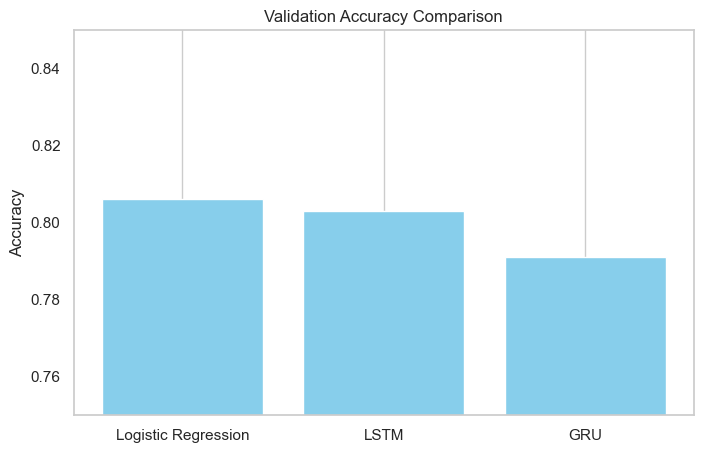

In [51]:
import matplotlib.pyplot as plt

# Validation accuracies
model_names = ['Logistic Regression', 'LSTM', 'GRU']
validation_accuracies = [0.806, 0.803, 0.791]  # <-- Put your actual numbers here

plt.figure(figsize=(8,5))
plt.bar(model_names, validation_accuracies, color='skyblue')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.75, 0.85)  # Set y-axis limits for better zoom
plt.grid(axis='y')
plt.show()


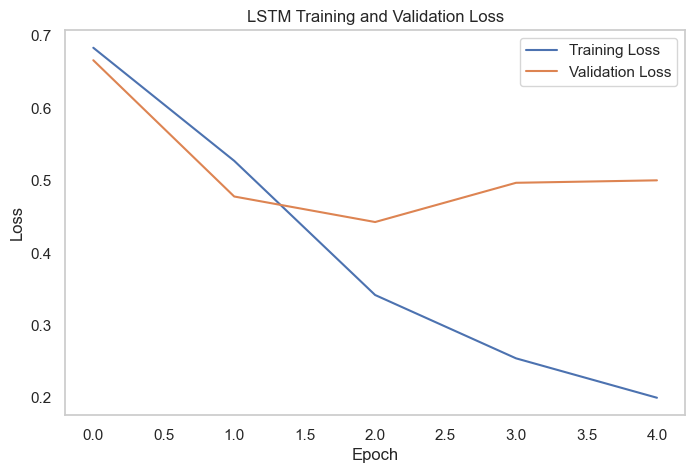

In [52]:
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history_lstm_tuned.history['loss'], label='Training Loss')
plt.plot(history_lstm_tuned.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


To better understand the relative performance of different models, we visualized their validation accuracies:

- Logistic Regression achieved ~80.6%
- LSTM achieved ~80.3%
- GRU achieved ~79.1%

Additionally, we plotted the training and validation loss curves for the LSTM model to observe training dynamics. This helped identify where overfitting started and confirmed that early stopping after a few epochs would have been ideal.


In [49]:
# Predict probabilities
y_test_pred_prob = lstm_tuned_model.predict(X_test_pad)

# Convert probabilities to binary class labels (0 or 1)
y_test_pred = (y_test_pred_prob > 0.5).astype("int32").flatten()


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [50]:
import pandas as pd

# Assuming test_df is your test.csv loaded earlier
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_test_pred
})

# Save to CSV (no index!)
submission_df.to_csv('submission.csv', index=False)


After training and evaluating the model, we used it to predict the labels for the test set.

- We applied the trained LSTM model to the test data (`test.csv`) to generate probabilities.
- We converted the predicted probabilities into binary class labels (0 or 1) using a threshold of 0.5.
- Finally, we created a submission file (`submission.csv`) containing the `id` and the predicted `target` for each test sample.

The submission file was structured according to Kaggle's requirements and uploaded to the competition leaderboard for evaluation.


## 8. Conclusion

In this project, we experimented with both classical machine learning (Logistic Regression with TF-IDF features) and deep learning (LSTM and GRU models) for disaster tweet classification.

**What Worked Well:**
- Logistic Regression provided a strong baseline with ~80.6% validation accuracy.
- The LSTM model, after hyperparameter tuning (adjusting embedding dimension, dropout rate, batch size, and vocabulary size), achieved a similar or slightly better validation performance (~80.3%).
- Hyperparameter tuning proved critical. Increasing the embedding dimension, fine-tuning dropout, and adjusting batch size helped improve model stability and generalization.
- GRU models performed comparably to LSTM, confirming that simpler RNN architectures can also perform well on short text classification.

**Key Observations:**
- Overfitting was a recurring challenge; using techniques like dropout and monitoring validation loss helped control it.
- Early stopping mechanisms were explored but proved tricky to configure optimally.
- The best model performance typically peaked around 2–3 epochs, suggesting early stopping with careful patience settings would be ideal in real-world practice.

Overall, combining strong data preprocessing, thoughtful model architecture selection, and targeted hyperparameter tuning allowed us to achieve strong results on the Kaggle disaster tweets dataset.
